# Mosaic Indices

<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Indices%20-%20composite.png" />

[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)

This product generates mosaics using Indices (NDVI, EVI, NDWI, NDDI). 


Indicies include Normalise Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI), Normalised Difference Water Index (NDWI) and Normalised Difference Drought Index (NDDI). 

### Import Required Modules

In [1]:
# jupyteronly
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
import datacube
from datacube_utilities.interactive_maps import display_map
from matplotlib.cm import RdYlGn, Greens, Blues
import matplotlib.pyplot as plt

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
from pyproj import Proj, transform
from datacube.utils.cog import write_cog

import dask
from dask.distributed import Client

import odc.algo
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


In [12]:
#import datacube utilities
import datacube_utilities.data_access_api as dc_api  
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic, create_min_ndvi_mosaic
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.clean_mask import landsat_qa_clean_mask

### Initialise

In [13]:
#Jupyteronly
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='indices mosaic')

### Set Parameters for cube query

In [14]:
#parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt",
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((177.43329863711836 -17.52948354640883,177.76975493594648 -17.52948354640883,177.76975493594648 -17.826499420595315,177.43329863711836 -17.826499420595315,177.43329863711836 -17.52948354640883))"

#set start and end dates for time period of interest
#parameter display_name="Start Date" description='Start of time period window' datatype="date"
baseline_time_start = '2019-1-1'
#parameter display_name="End Date" description='End of time period window' datatype="date"
baseline_time_end = '2019-4-1'

#parameter display_name="Sensor" description="Satellite to use." datatype="string" options=["SENTINEL_2", "LANDSAT_4", "LANDSAT_5", "LANDSAT_7", "LANDSAT_8"],
platform = "LANDSAT_8"

#set resolution
#parameter display_name="Resolution (m)" description="Size of pixels" datatype="int"
res = (30)

#parameter display_name="Mosaic Type" description="The type of mosaic." datatype="string" options=["max", "median", "min", "mean"],
mosaic_type = "median"

#parameter display_name="Indices Type" description="The type of Indices." datatype="string" options=["EVI", "NDVI", "NDDI", "NDWI_green", "NDWI_SWIR"],
indices = "NDWI_Green"

#parameter display_name="Coordinate Reference System (ESPG Code)" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"


### Reformat parameters

In [15]:
#createAOI
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [16]:
# jupyteronly
#render map to check AOI
display_map(latitude = lat_extents, longitude = lon_extents)

In [17]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3926662.098051653, 3934403.928509868)
(2024382.843073529, 2030659.4223828027)


In [18]:
def relevantBands(indices):
    if indices == 'NDVI':
        ISMeasurements = ['nir', 'red']
    if indices == 'NDWI_Green':
        ISMeasurements = ['nir', 'green']
    if indices == 'NDWI_SWIR':
        ISMeasurements = ['nir', 'swir1']
    if indices == 'NDDI':
        ISMeasurements = ['nir', 'red', 'green']
    if indices == 'EVI':
        ISMeasurements = ['nir', 'red', 'blue']
    return(ISMeasurements)

allmeasurements = relevantBands(indices)   

In [19]:
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [20]:
#create resolution
resolution = (-res, res)

In [21]:
dask_chunks=dict(
    time = 10,
    x=2000, 
    y=2000
)

In [22]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': "EPSG:"+crs,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements,
    'dask_chunks' : dask_chunks,
    'crs': "EPSG:"+crs
}

In [35]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
time_range = createDate(baseline_time_start, baseline_time_end)

### Load data based on cube query

In [24]:
loaded_ds = dc.load(
    time = time_range,
    **query
)

### Check if loads are valid

In [25]:
#check if loads have returned valid data
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(loaded_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

### Mask Cloud

In [27]:
if platform  in ["SENTINEL_2"]:
    clean_mask = (
        (loaded_ds.scene_classification == 4) | # clear
        (loaded_ds.scene_classification == 5) | 
        (loaded_ds.scene_classification == 7) | 
        (loaded_ds.scene_classification == 2) | 
        (loaded_ds.scene_classification == 6)  #water
    )
elif platform in ["LANDSAT_8"]:  
    clean_mask = (
        (loaded_ds.pixel_qa == 322)  | # clear
        (loaded_ds.pixel_qa == 386)  |
        (loaded_ds.pixel_qa == 834)  |
        (loaded_ds.pixel_qa == 898)  |
        (loaded_ds.pixel_qa == 1346) |
        (loaded_ds.pixel_qa == 324)  | # water
        (loaded_ds.pixel_qa == 388)  |
        (loaded_ds.pixel_qa == 836)  |
        (loaded_ds.pixel_qa == 900)  |
        (loaded_ds.pixel_qa == 1348)
    )
elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
    clean_mask = (
        (loaded_ds.pixel_qa == 66)  | # clear
        (loaded_ds.pixel_qa == 130)  |
        (loaded_ds.pixel_qa == 68)  | # water
        (loaded_ds.pixel_qa == 132)  
    )
else:
    print("invalid platform")
    
clean_mask

<xarray.DataArray 'pixel_qa' (time: 5, y: 259, x: 210)>
dask.array<or_, shape=(5, 259, 210), dtype=bool, chunksize=(5, 259, 210), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T22:06:28 ... 2019-03-18T22:...
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460

In [28]:
loaded_ds = loaded_ds.where(clean_mask)
loaded_ds

<xarray.Dataset>
Dimensions:      (time: 5, x: 210, y: 259)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-13T22:06:28 ... 2019-03-18T22:...
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(5, 259, 210), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [29]:
maskoutofrange = ((loaded_ds > 0) & (loaded_ds <= 10000))
maskoutofrange2 = loaded_ds.where(maskoutofrange != 0)
loaded_ds = maskoutofrange2

In [30]:
# jupyteronly
#loaded_ds.nir.plot(cmap="RdYlGn", robust=True, col="time", vmin=0, vmax=10000, col_wrap=2)
#plt.show()

## Perform Mosaic

In [31]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,                   
                   "mean": create_mean_mosaic,
                   "min": create_min_ndvi_mosaic
                  }

In [32]:
mosaic_compositor = mosaic_function[mosaic_type]
mosaic_compositor

<function datacube_utilities.dc_mosaic.create_median_mosaic(dataset_in, clean_mask=None, no_data=nan, dtype=None, **kwargs)>

In [33]:
%%time
if mosaic_type == "median" or mosaic_type == "mean":
    mosaiced_composite = mosaic_compositor(loaded_ds, clean_mask=clean_mask)
else:
    mosaiced_composite = dask.delayed(mosaic_compositor)(loaded_ds, clean_mask = clean_mask)
mosaiced_composite

CPU times: user 75.7 ms, sys: 3.9 ms, total: 79.6 ms
Wall time: 91.5 ms


<xarray.Dataset>
Dimensions:      (x: 210, y: 259)
Coordinates:
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460
Data variables:
    nir          (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>
    green        (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>
    pixel_qa     (y, x) float64 dask.array<chunksize=(259, 210), meta=np.ndarray>

In [34]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [35]:
#from within DCAL_Land_Change Script
def EVI(dataset):
    ds = dataset/10000
    return 2.5*(ds.nir - ds.red)/(ds.nir + 6.0*ds.red - 7.5*ds.blue + 1)

In [36]:
def NDWI_Green(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [37]:
def NDWI_SWIR(dataset):
    return (dataset.nir - dataset.swir1)/(dataset.nir + dataset.swir1)

In [38]:
def NDDI(dataset):
    aNDVI = NDVI(dataset)
    aNDWI = NDWI(dataset)
    return (aNDVI - aNDWI)/(aNDVI + aNDWI)

## Calculate Indices and Plot

In [39]:
indices_function = {"NDVI": NDVI, "NDWI_Green": NDWI_Green, "NDWI_SWIR": NDWI_SWIR, "EVI": EVI, "NDDI": NDDI}
indices_compositor = indices_function[indices]
indices_composite = indices_compositor(mosaiced_composite)
indices_composite

<xarray.DataArray (y: 259, x: 210)>
dask.array<truediv, shape=(259, 210), dtype=float64, chunksize=(259, 210), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x            (x) float64 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
    spatial_ref  int32 3460

In [40]:
# jupyteronly
#%%time
indices_composite = indices_composite.compute()

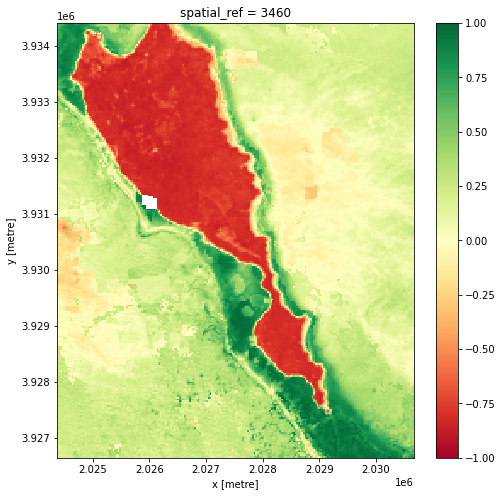

In [41]:
# jupyteronly
plt.figure(figsize = (8,8))
if indices in ["NDVI"]:
    indices_composite.plot(vmin=0, vmax=1, cmap = RdYlGn)
elif indices in ["NDWI_Green"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = RdYlGn)
elif indices in ["EVI"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = RdYlGn)
elif indices in ["NDDI"]:
    indices_composite.plot(vmin=-30, vmax=30, cmap = RdYlGn)
else:
    print('indicies invalid')


### Exports

In [95]:
#Write as GeoTIFF
write_cog(geo_im=indices_composite,
          fname='indices.tif',
          overwrite=True)

PosixPath('indices_composite.tif')

In [96]:
#write as Tiff
#write_geotiff_from_xr('indices_composite.tiff', indices_composite, ["index"], crs="EPSG:"+crs, x_coord = 'x', y_coord = 'y')

In [58]:
#naming exports for ESRI to pick up
['indices.tif']

['indices_composite.tif']

---